In [38]:
# BLOCK 1: Imports
import pandas as pd
import numpy as np
import os # CHANGED: Added 'os' for creating directories and managing file paths
import joblib # CHANGED: Added 'joblib' for saving the model and encoders
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import optuna

print("--- Data Loading and Preprocessing ---")

--- Data Loading and Preprocessing ---


In [39]:
# Block 2: Load and preprocess dataset
# Make sure to update the file path to where your dataset is located.
try:
    df = pd.read_csv(r"C:\Users\aruna\OneDrive\Desktop\Major-Pro\DATASET\Processed\cleaned_final_data.csv")
except FileNotFoundError:
    print("Error: Dataset file not found. Please update the path in Block 2.")
    exit()

# Remove missing target rows
df = df.dropna(subset=["current_value"])

# Log-transform target to stabilize outliers
df["current_value"] = np.log1p(df["current_value"])

# Clip extreme outliers at 99th percentile
clip_val = df["current_value"].quantile(0.99)
df["current_value"] = np.clip(df["current_value"], None, clip_val)

# Example engineered feature: Age Bucket
df["age_bucket"] = pd.cut(df["age"], bins=[0,20,25,30,35,100],
                        labels=["<20","20-25","25-30","30-35","35+"])

print("Dataset loaded and initial processing complete.")



Dataset loaded and initial processing complete.


In [40]:
# Block 3: Label encode categorical variables
# CHANGED: Storing encoders in a dictionary is a major change.
# This is crucial for correctly processing new data in your Flask app.
cat_cols = ["team", "position", "age_bucket"]
encoders = {} # CHANGED: Initialized a dictionary to hold the fitted encoders
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le # CHANGED: Saved the fitted encoder for each column
    print(f"Label encoded '{col}' column.")

# Features & target
X = df.drop(columns=["current_value"])
y = df["current_value"]

Label encoded 'team' column.
Label encoded 'position' column.
Label encoded 'age_bucket' column.


In [41]:
# Block 4: KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [42]:
# Block 5: Baseline model score
print("\n--- Baseline Model Evaluation ---")
model = lgb.LGBMRegressor(random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
print(f"Baseline CV R²: {scores.mean()}")



--- Baseline Model Evaluation ---
Baseline CV R²: 0.49043703426927615
Baseline CV R²: 0.49043703426927615


In [43]:
# BLOCK 6: Hyperparameter tuning with Optuna
print("\n--- Hyperparameter Tuning with Optuna ---")

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "n_estimators": 1000, # A fixed high number, early stopping will find the best
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    callbacks = [lgb.early_stopping(100, verbose=False)]
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train, 
        eval_set=[(X_valid, y_valid)], 
        eval_metric="rmse", 
        callbacks=callbacks,
        categorical_feature=cat_cols  # <--- THIS IS THE ADDED LINE
    )
    
    preds = model.predict(X_valid)
    r2 = r2_score(y_valid, preds)
    return r2

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True) # Using 10 trials for speed, you can increase this
print(f"Best Params from Optuna: {study.best_params}")
print(f"Best CV R² from Optuna: {study.best_value}")

[I 2025-11-04 15:13:09,985] A new study created in memory with name: no-name-5e914856-9a4e-4839-924a-2e26abd9cf62



--- Hyperparameter Tuning with Optuna ---


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-11-04 15:13:11,700] Trial 0 finished with value: 0.5630637253079132 and parameters: {'learning_rate': 0.0136366523814061, 'num_leaves': 252, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.585570382678505, 'colsample_bytree': 0.6008909789566209}. Best is trial 0 with value: 0.5630637253079132.
[I 2025-11-04 15:13:14,105] Trial 1 finished with value: 0.57393369792424 and parameters: {'learning_rate': 0.014988933045521282, 'num_leaves': 155, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.7043254879746488, 'colsample_bytree': 0.7628344717846862}. Best is trial 1 with value: 0.57393369792424.
[I 2025-11-04 15:13:14,105] Trial 1 finished with value: 0.57393369792424 and parameters: {'learning_rate': 0.014988933045521282, 'num_leaves': 155, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.7043254879746488, 'colsample_bytree': 0.7628344717846862}. Best is trial 1 with value: 0.57393369792424.
[I 2025-11-04 15:13:14,795] Trial 2 finished with value: 0.569619159

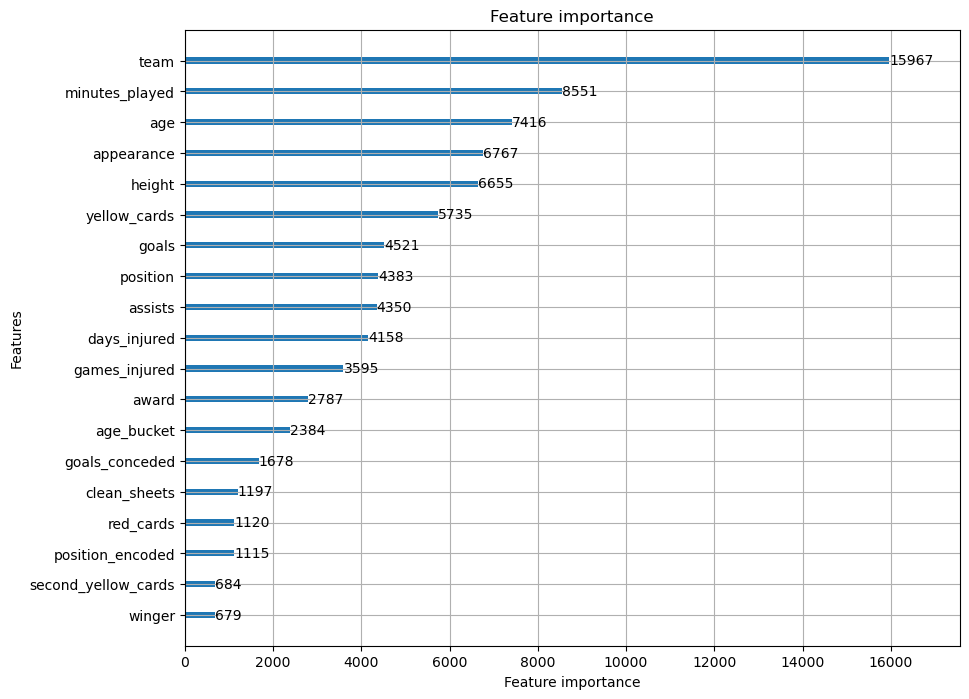

In [44]:
import matplotlib.pyplot as plt
lgb.plot_importance(final_model, max_num_features=20, figsize=(10, 8))
plt.show()

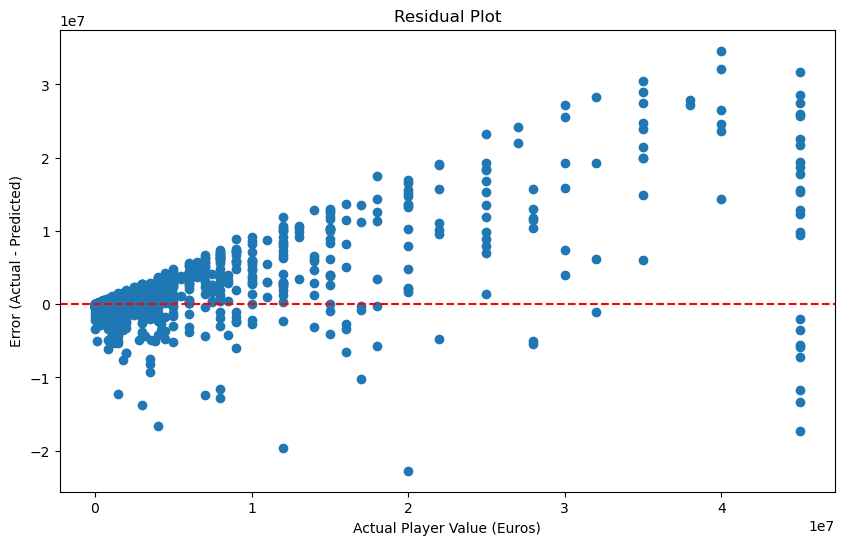

In [45]:
# Get predictions from your validation set
y_pred = final_model.predict(X_valid)

# It's better to plot the *actual values* (not the log-transformed ones)
actual_value = np.expm1(y_valid)
predicted_value = np.expm1(y_pred)

residuals = actual_value - predicted_value

plt.figure(figsize=(10, 6))
plt.scatter(actual_value, residuals)
plt.title("Residual Plot")
plt.xlabel("Actual Player Value (Euros)")
plt.ylabel("Error (Actual - Predicted)")
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [46]:
# BLOCK 7: Train the final model with best parameters
print("\n--- Training Final Model ---")
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# CHANGED: Fixed the TypeError from the notebook by correctly combining parameters.
final_params = study.best_params
final_params['random_state'] = 42
final_params['n_estimators'] = 5000 # High number for early stopping
final_params['objective'] = 'regression'
final_params['metric'] = 'rmse'

final_model = lgb.LGBMRegressor(**final_params)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100, verbose=True)],
    categorical_feature=cat_cols  # <--- THIS IS THE ADDED LINE
)

print(f"Final model trained. Best iteration: {final_model.best_iteration_}")

y_pred = final_model.predict(X_valid)
r2 = r2_score(y_valid, y_pred)
print(f"Final Model R² on Validation Set: {r2}")


--- Training Final Model ---
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1107]	valid_0's rmse: 1.60637
Early stopping, best iteration is:
[1107]	valid_0's rmse: 1.60637
Final model trained. Best iteration: 1107
Final Model R² on Validation Set: 0.5829597590989242
Final model trained. Best iteration: 1107
Final Model R² on Validation Set: 0.5829597590989242


In [48]:
# BLOCK 8: Save the model and encoders
# CHANGED: This entire block is new. It handles saving the necessary files.
print("\n--- Saving Model and Encoders ---")

if not os.path.exists('models'):
    os.makedirs('models')
    print("Created 'models' directory.")

model_path = os.path.join('models', 'lgbm_model.pkl')
encoders_path = os.path.join('models', 'label_encoders.pkl')

joblib.dump(final_model, model_path)
print(f"Model saved to: {model_path}")

joblib.dump(encoders, encoders_path)
print(f"Encoders saved to: {encoders_path}")


--- Saving Model and Encoders ---
Model saved to: models\lgbm_model.pkl
Encoders saved to: models\label_encoders.pkl
